In [1]:
## IMPORTING LIBRARIES

import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mafthematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files
import scipy.signal as signal 
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline, BSpline
from scipy.spatial import ConvexHull
from GP_functions1 import GP_train, GP_predict

In [2]:
# KEY PARAMETERS USED THROUGHOUT MODEL

a = 350 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = np.float64(200000000) # Budget in £ to build the wind farm, accounting for construction costs.
DistanceToShore = 15000 # m #distance of the wind farm from shore
TooCloseShore = 5000 # m # minimum distance the wind farm must be from shore
xCoordOnshoreSub = 0 # x coordinate of the onshore substation (y coordinate is -(DistanceToShore))

USDtoGBP = 1/1.351  
EURtoGBP = 1/1.19

IACableCostperMeter = 409.2*EURtoGBP
ExportCableCostperMeter = 833.625*EURtoGBP

CostperTurbineUSD = np.float64(3000000) # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostsperAnnum = np.float64(65500) # GBP
LifeTimeTurbineOperatingTime = 20 # years 120000 # hours
MaintenanceCostperTurbine = OperatingandMaintenanceCostsperAnnum*LifeTimeTurbineOperatingTime # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP

OffshoreSubstationCostperMW = np.float64(104000*EURtoGBP)
OnshoreSubstationCostperMW = np.float64(87250*EURtoGBP)
# Costs  associated with the purchase and installation of electrical substations as well as the buildings required for housing the staff and additional equipment required for the running of the wind farm.

ElectricityCostperkWh = 0.144 # 14.4 pence - £0.144
DiscountRate = 0.07 # 7%

TurbineRating = 2 #2MW

GravityBase = 409000*EURtoGBP*TurbineRating #409000euro/MW
Monopile = 551000*EURtoGBP*TurbineRating
Jacket = 665000*EURtoGBP*TurbineRating
TensionLeg = 1163000*EURtoGBP*TurbineRating

In [3]:
#READING IN BATHYMETRY DATA
data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'    
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [4]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.    
maxnodespertree = maximumturbinespertree # As above
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result
MinIACableCostPerTurbine = a*IACableCostperMeter
MinExportCableCost = TooCloseShore*ExportCableCostperMeter # minimum export cable cost with respect to the minimum distance the wind farm must be form shore
MinFoundationCostPerTurbine = GravityBase*TurbineRating

MinCostperTurbTot = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine+MinIACableCostPerTurbine+MinFoundationCostPerTurbine # Total costs (excluding export cable and fixed costs)
nnturb = (budget-MinExportCableCost)/MinCostperTurbTot 
FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nnturb*TurbineRating # *2 due to 2MW turbines being used *0.4 for assuming 40% effciency
nturb = (budget-FixedCost-MinExportCableCost)/(MinCostperTurbTot) # Turbines possible with current budget
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3615.099925980903
Min area per turbine = 106088.11196359372 m^2
Min area = 3713083.91872578 m^2
Max number of turbines = 35
Max area = 272798002.19209814 m^2


In [5]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-0.5a,-0.5aroot3) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
        
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)

[[    0.             0.        ]
 [  350.             0.        ]
 [  525.           303.10889132]
 [  175.           303.10889132]
 [ -175.           303.10889132]
 [ -350.             0.        ]
 [ -525.          -303.10889132]
 [ -175.          -303.10889132]
 [  175.          -303.10889132]
 [  525.          -303.10889132]
 [  700.             0.        ]
 [  875.           303.10889132]
 [ 1050.           606.21778265]
 [  700.           606.21778265]
 [  350.           606.21778265]
 [    0.           606.21778265]
 [ -350.           606.21778265]
 [ -525.           303.10889132]
 [ -700.             0.        ]
 [ -875.          -303.10889132]
 [-1050.          -606.21778265]
 [ -700.          -606.21778265]
 [ -350.          -606.21778265]
 [    0.          -606.21778265]
 [  350.          -606.21778265]
 [  700.          -606.21778265]
 [  875.          -303.10889132]
 [ 1050.             0.        ]
 [ 1225.           303.10889132]
 [ 1400.           606.21778265]
 [ 1575.  

In [6]:
# Shoreline implementation

XShoreLine = np.array([np.linspace(min(positionlist[:,0])-2500,max(positionlist[:,0])+2500,1000)]) #Creates x coordinates of shoreline bewtween min and max turbine locations +/- 1000m # 1000 data points
YShoreLine = np.array([np.linspace(-DistanceToShore,-DistanceToShore,1000)]) #Creates y coordinates of shoreline at -(distance of the wind farm from the shore) # 1000 data points
TXShoreLine = np.transpose(XShoreLine) #transpose of x coordinates
TYShoreLine = np.transpose(YShoreLine) #transpose of y coordinates
TShoreLine = np.concatenate((TXShoreLine,TYShoreLine),axis=1) # Shoreline (x,y)

In [7]:
# Finds distance between substation and shore

def Substation_To_Shore_Connection(positionlist):
    
    OnshoreSubstation = [xCoordOnshoreSub,-DistanceToShore] # Determines fixed position of onshore substation
    ExportDistance = np.sqrt(((positionlist[0,0]-OnshoreSubstation[0])**2)+((positionlist[0,1]-OnshoreSubstation[1])**2)) # min Hypotenuse for distances between substations
    
    return OnshoreSubstation,ExportDistance

OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist) #Initially Executes algorithm

print(OnshoreSubstation)
print(np.shape(OnshoreSubstation))
print(ExportDistance)

[0, -15000]
(2,)
15000.0


In [8]:
# Pushes wind farm further out if the smallest distance between the shore and center of wind farm is too small
# Only used for the pre-optimised layout
#In terms of keeping it this way there are bounds on (minimize(targetfunction, initial guess, bounds,.....etc.) the optimization function

CloseTurbY = min(positionlist[:,1]) # y coordinate of closest turbine
CloseTurbYindex = np.argmin(positionlist[:,1]) # index from closest turbine on y axis
CloseTurbX = positionlist[CloseTurbYindex,0] # x coordinate of closest turbine on y axis
DistanceToMinTurb = min(np.sqrt((CloseTurbX-TXShoreLine[:,0])**2+(CloseTurbY-TYShoreLine[:,0])**2)) #min distance from shore to closest turbine 
s = 0

if DistanceToMinTurb < TooCloseShore: # if closest turbine is too close to the shore
    for s in range(0,nturb+1): # loops for number of turbines plus the substation
        positionlist[s,1] = positionlist[s,1] + (TooCloseShore-DistanceToMinTurb)
        # Shifts entire wind farm up by the difference to achieve the minimum distance required
    Substation_To_Shore_Connection(positionlist) #Calls function to redo substation to shore connection with new values

(-16606.217782649106, -706.217782649107)

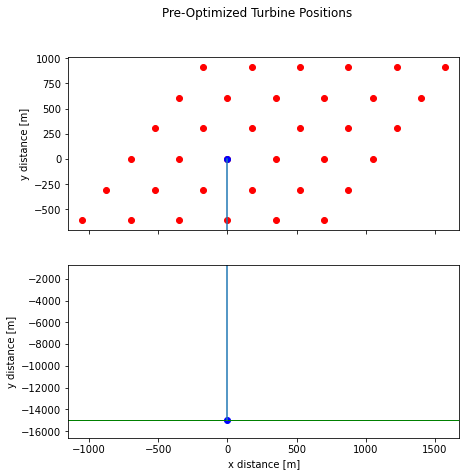

In [9]:
# Display pre-optimized turbine positions before clustering and MST

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)    
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

In [10]:
#Function to determine land cost of wind farm using a convex hull
#Calcualtes area of wind farm, onshore substation, and export cable
#Won't work for just 1 turbine since no boundary to enclose

def LandAreaCost(positionlist,ExportDistance):
    
    radius = 130 #m
    OnshoreSubLand = np.pi*radius**2 #Land area associated with the onshore substation
    ExportLand = ExportDistance*8 # Length*width 
    
    hull = ConvexHull(positionlist) #computes convex hull using the turbine positions
    LandArea = hull.volume + OnshoreSubLand + ExportLand #Calcualtes convex hull area and adds on the onshore substation land area

    LandCost = LandArea*LandCostpermSquared
    
    return LandCost

LandCost = LandAreaCost(positionlist,ExportDistance)

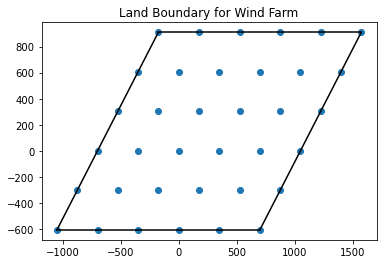

In [11]:
#Visual aid for convex hull plotting

hull = ConvexHull(positionlist)
plt.plot(positionlist[:,0], positionlist[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(positionlist[simplex, 0], positionlist[simplex, 1], 'k-')


plt.title('Land Boundary for Wind Farm')
plt.show()

 C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning:Spaces are not permitted in the name. Converted to '_'


Function run time: 0.2357157999999977
[[   0    1    2    8    9   10   24   25   26   27 -100]
 [   0    5    6    7   17   18   19   20   21   22   23]
 [   0    3    4   14   15   16   34   35 -100 -100 -100]
 [   0   11   12   13   28   29   30   31   32   33 -100]]


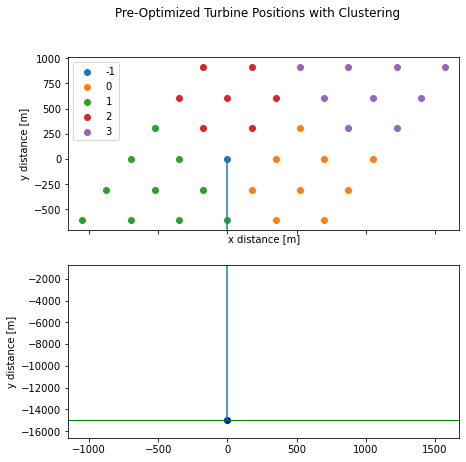

In [12]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustering')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
for i in u_labels: # loops for number of turbines
    ax1.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax1.legend() # prints legend
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

print(indiceslist)

In [13]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

#distance_global - distances of each turbine with respect to the substation and each other h=sqrt(x^2+y^2)
#e.g. row 0 would be each turbines distance with respect to the substation
# and row 4 would be each turbines distance with respect to the 4th turbine as found in the position list
# distance_globl[i,i] = 1e10 since this is the distance of each turbine with respect to itself so we want the MST to ignore thse values
#angle_global - angle of each turbine with respect to the substation and each other arctan(y/x)
#distance and angle then do something similar but considering the cluster formations as well

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1) # Everything except the -100 ones which were denoted earlier to show that there is no turbine at that index
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [14]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()
    return MSTweight

Each tree weight tree 1 3150000.0
Each tree weight tree 2 3500000.0
Each tree weight tree 3 2450000.0
Each tree weight tree 4 3726012.958872607
MST total weight 12826012.958872607 m


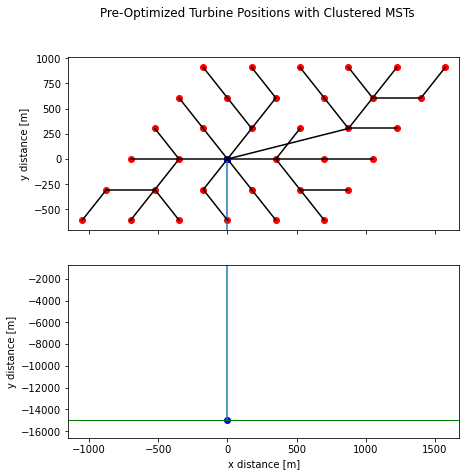

In [15]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustered MSTs')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax1.plot(u,v, c='black')
        ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue')
        
print('MST total weight', MSTWeightSum, 'm')

In [16]:
#DISPLAYS RAW BATHYMETRY DATA

#print(data) # Prints out bathymetry data - Read in using pandas in previous section

In [17]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

#print(data) 

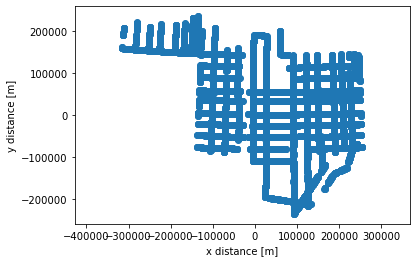

In [18]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

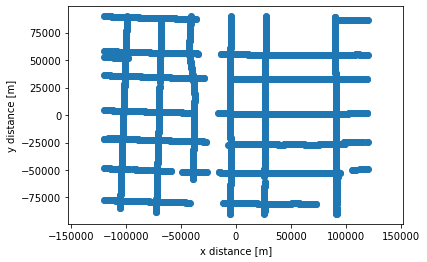

In [19]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

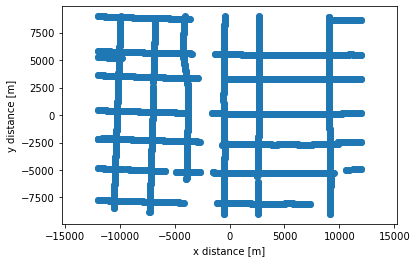

In [20]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

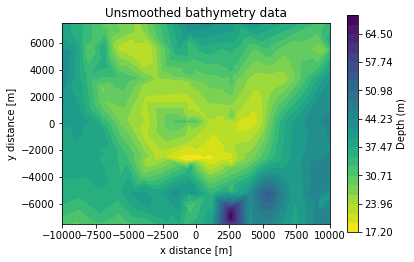

In [21]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

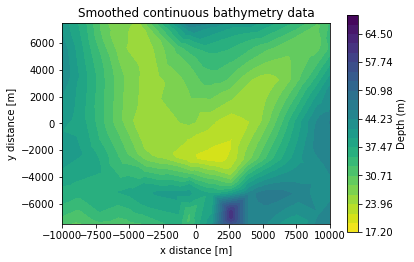

In [22]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [23]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = np.float64(0) # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

(5634628.501841279, 23.394764925387133, 27.392063228618998)

In [24]:
smooth

In [25]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=5. #[degrees]

In [26]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

6.512913707119303

In [27]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=5 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [28]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


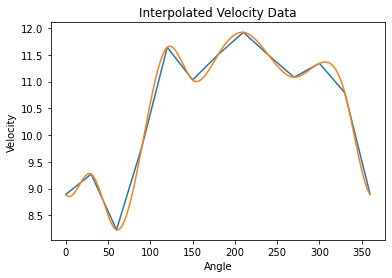

In [29]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

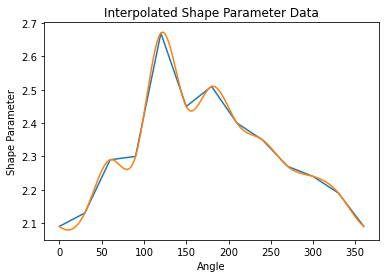

In [30]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

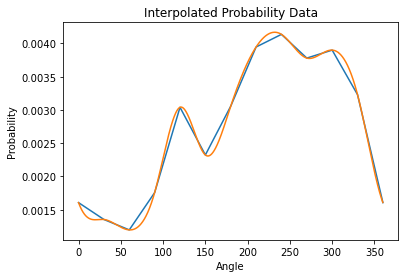

In [31]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree


windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [32]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

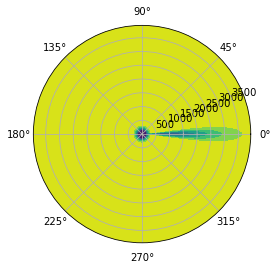

0.580003843


In [33]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [34]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [35]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [36]:
## (USED IN TARGET FUNC)
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [37]:
## GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [38]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [39]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [40]:
wind_dist(1.0,v0)

0.024244336764100854

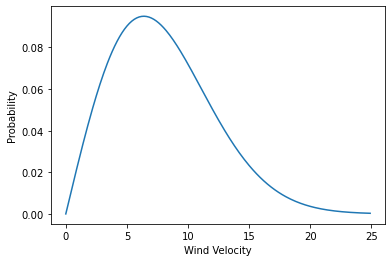

In [41]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [42]:
velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)
print(angles)
print(velocities)
print(dang)

[[7.95303494e-04 9.80036676e-04 1.05789271e-03 ... 6.39190809e-05
  3.40253887e-05 1.70630457e-05]
 [7.34767202e-04 9.01764403e-04 9.69915308e-04 ... 5.75583274e-05
  3.06371248e-05 1.53701909e-05]
 [6.87320078e-04 8.44491359e-04 9.10294073e-04 ... 5.77144043e-05
  3.11157981e-05 1.58295009e-05]
 ...
 [9.80182139e-04 1.25683306e-03 1.41621103e-03 ... 1.55577912e-04
  9.05953796e-05 4.99151675e-05]
 [9.27369324e-04 1.17045619e-03 1.29626789e-03 ... 1.10756647e-04
  6.20462178e-05 3.28196113e-05]
 [8.63068120e-04 1.07416013e-03 1.17166708e-03 ... 8.08008629e-05
  4.38237311e-05 2.24068824e-05]] (72, 14) 0.9458659589195532
(14,)
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355.]

In [43]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

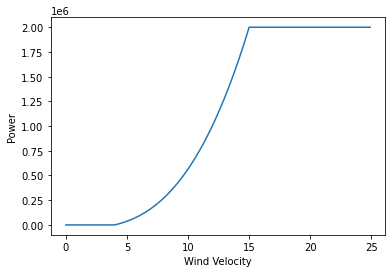

In [44]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [45]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

In [46]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

[867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078] (35,) 30350623.10282737


In [47]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [48]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [49]:
## IMPORTING WIND DIRECTION DATA
## north = 0 degrees
direction_data = pd.read_csv('Directiondata.csv')
wind_directions = directiondata['Angle']
wind_directions = pd.DataFrame(wind_directions).to_numpy()
wind_directions = np.transpose(wind_directions)

In [50]:
## FUNCTION: SIMPLE ROTATE
def rotate(angle, coords):
    angle = np.pi*angle/180.
    rot_x_corrds = []
    rot_y_corrds = []
    for coord in coords:
        rot_x_corrds += [coord[0]*np.cos(angle) - coord[1]*np.sin(angle)]
        rot_y_corrds += [coord[0]*np.sin(angle) + coord[1]*np.cos(angle)]
    rot_coords = [rot_x_corrds,rot_y_corrds]
    rot_coords = np.array(rot_coords).T
    return rot_coords

In [51]:
# TRAIN MODEL and assign to predicting class
name = "all_dataset.csv"
training_class = GP_train() # create training class
training_model = training_class.train_model() # trains model on "all_dataset.csv"

# CREATE PREDICTING CLASS from which attenuation predictions are made
predict_class = GP_predict(training_model) # create predicting class

In [52]:
## OLD WINDSPEED REDUCTION FUNCTION (USED IN TARGET FUNC)
## description: calculates the % of wind that arrives at a turbine for a certain angle.
## Starts with assumption that there's zero wake so all turbines get full wind.
def windspeedreduction_old(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. n turbine rows, n direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.
    
## TESTING   
distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist)
print(f'OLD WSR')
print(f'positionlist.shape = {positionlist.shape}')

print(f'angles.shape = {angles.shape}     (number of wind angles!)')
wsr=windspeedreduction_old(distance_global,angle_global,angles,model) ## old WSR function
# np.set_printoptions(threshold=np.inf)
# print(f'wsr = \n{wsr}')
# np.set_printoptions(threshold=1000)
print(f'type(wsr) = {type(wsr)}\nwsr.shape = {wsr.shape}\nCONCLUSION: the first dimension (y = {wsr.shape[0]}) is nturb, the second dimension (x = {wsr.shape[1]}) is ndir')

OLD WSR
positionlist.shape = (36, 2)
angles.shape = (72,)     (number of wind angles!)
type(wsr) = <class 'numpy.ndarray'>
wsr.shape = (35, 72)
CONCLUSION: the first dimension (y = 35) is nturb, the second dimension (x = 72) is ndir


In [53]:
## FUNCTION: WIND SPEED REDUCTION (WSR) (NEW!)
## description: returns a matrix of wind attenuation with nturb turbine rows, ndir direction columns
def windspeedreduction(positionlist,directions,g_model):
    ndir = int(np.size(directions))
    nturb = int(np.size(positionlist)/2)
    total_att=np.ones((nturb,ndir))
    for i in range(0,ndir):
        angle_to_rotate = 90 + directions[i];
        westerly_pos_list = rotate(angle_to_rotate,positionlist) # rotate position list for westerly wind
        att_vector = g_model.predict(westerly_pos_list, nturb) # vector of attenuations (from GP_functions module)
        att_vector = att_vector.reshape(nturb,)
        total_att[:,i] = att_vector
    total_att = total_att/8 ## Get attenuation as a fraction compared to the assumed base wind speed in gaussian model of 8 m/s
    return total_att

## TESTING
wind_directions_for_WSR = wind_directions[0]
print('NEW WSR')
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
print(f'positionlist.shape = {positionlist.shape}')
print(f'wind_directions_for_WSR.shape = {wind_directions_for_WSR.shape}     (number of wind angles!)')
print(f'type(wsr) = {type(wsr)}\nwsr.shape = {wsr.shape}\nCONCLUSION: the first dimension (y = {wsr.shape[0]}) is nturb, the second dimension (x = {wsr.shape[1]}) is ndir')

NEW WSR


 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos


positionlist.shape = (36, 2)
wind_directions_for_WSR.shape = (13,)     (number of wind angles!)
type(wsr) = <class 'numpy.ndarray'>
wsr.shape = (35, 72)
CONCLUSION: the first dimension (y = 35) is nturb, the second dimension (x = 72) is ndir


In [54]:
powout=power(wsr,velocities); # total output power
output=np.tensordot(powout,wsp,axes=2);

 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


In [55]:
def foundationDepthCost(foundation,DepthPerTurbine):
    
    FoundationCost = foundation*(0.0002*(float(DepthPerTurbine)**2) - 0.0002*(float(DepthPerTurbine)) + 0.9459)
    
    return FoundationCost

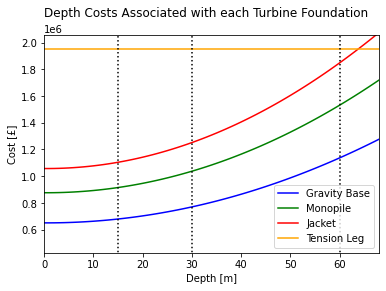

In [56]:
# Plots depth functions for each individual turbine foundation type

Depthx = range(0,math.ceil((max(data['CORR_DEPTH']))),1)
GBCost = [None] * len(Depthx)
MPCost = [None] * len(Depthx)
JCost = [None] * len(Depthx)
TLCost = [None] * len(Depthx)
Depth = 0

for i in Depthx:
    GBCost[i] = foundationDepthCost(GravityBase,Depth)
    MPCost[i] = foundationDepthCost(Monopile,Depth)
    JCost[i] = foundationDepthCost(Jacket,Depth)
    TLCost[i] = TensionLeg
    Depth += 1
    
fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with each Turbine Foundation')

x1 = np.linspace(15,15,100)
x2 = np.linspace(30,30,100)
x3 = np.linspace(60,60,100)
y = np.linspace(0,TensionLeg+500000,100)

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx,GBCost,'blue')
ax.plot(Depthx,MPCost,'green')
ax.plot(Depthx,JCost,'red')
ax.plot(Depthx,TLCost,'orange')
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

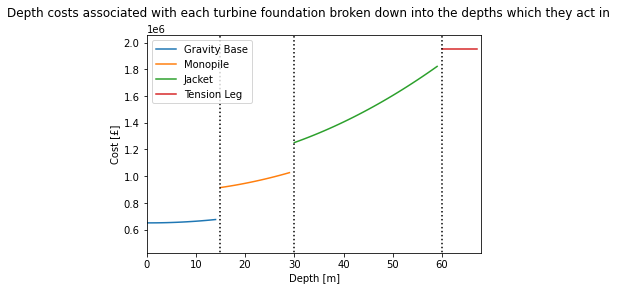

In [57]:
# Plots depth functions for each individual turbine foundation type but only considers the depths for which the foundation will act in

GBCost2 = GBCost[Depthx[0]:Depthx[15]]
MPCost2 = MPCost[Depthx[15]:Depthx[30]]
JCost2 = JCost[Depthx[30]:Depthx[60]]
TLCost2 = TLCost[Depthx[60]:max(Depthx)]

fig, ax = plt.subplots()
fig.suptitle('Depth costs associated with each turbine foundation broken down into the depths which they act in')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:15],GBCost2)
ax.plot(Depthx[15:30],MPCost2)
ax.plot(Depthx[30:60],JCost2)
ax.plot(Depthx[60:max(Depthx)],TLCost2)
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

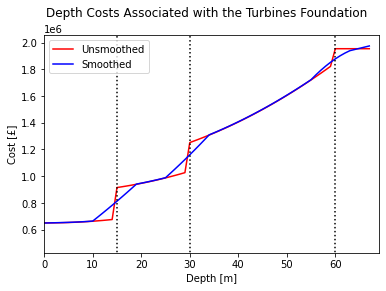

In [58]:
# Combines all the indivdual depths costs over there used depths into one plot and smooths the data

GBMPJTL = GBCost2+MPCost2+JCost2+TLCost2

fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with the Turbines Foundation')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH'])))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:max(Depthx)],GBMPJTL,color='r')
smoothed_2dg = savgol_filter(GBMPJTL, window_length = 9, polyorder = 1)
ax.plot(Depthx[0:max(Depthx)], smoothed_2dg, color='b')
plt.legend(['Unsmoothed','Smoothed'])
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')

In [59]:
def foundations(positionlist):
    
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    FoundationCost = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    FoundationCostTotal = 0 # Assigns initial value to variable
    
    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1])
        
        FoundationCost[i] = np.interp(DepthPerTurbine[i],Depthx[0:max(Depthx)],smoothed_2dg)

        FoundationCostTotal += FoundationCost[i]
        
    return FoundationCostTotal

FoundationCostTotal = foundations(positionlist)

In [60]:
# Function for calculated payback time, discounted payback time, Net Present Value, and Profitability Index

def Payback(TPO,TotalCost,positionlist):
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation at positonlist[0,:]
    
    CashFlowYearly = (ElectricityCostperkWh*24*365*(TPO/1000))-(OperatingandMaintenanceCostsperAnnum*nturb) # Calculates the yaerly cash flow for the windfarm
    PayBackTime = TotalCost/CashFlowYearly # calculates payback time in years
    DiscountedPayBackTime = (np.log(1/(1-((TotalCost*DiscountRate)/CashFlowYearly))))/np.log(1+DiscountRate) #Calculates payback time but takes into account the time value of money
    
    l=0
    NPV = 0
    
    for l in range(LifeTimeTurbineOperatingTime):
        l+=1
        NPV = NPV + (CashFlowYearly)/((1+DiscountRate)**l) #NPV is a method used to determine the current value of future cash flows generated by the project
    
    NPV = NPV - TotalCost
    ProfIndex = (NPV+TotalCost)/TotalCost # Probability index >1 it's profitable <1 its not
    
    return PayBackTime,DiscountedPayBackTime,NPV,ProfIndex

In [61]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance):
    
    mindepth = depthvalues(positionlist)[1]
    maxdepth = depthvalues(positionlist)[2]
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
    fig.suptitle('Plot Showing Sea Floor Topography and Turbines with Cables')
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    ax1.set_ylabel('y distance [m]') # y axis label
    ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    ax2.set_xlabel('x distance [m]') # x axis label
    ax2.set_ylabel('y distance [m]') # y axis label
    ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits
    
    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            ax1.plot(u,v, c='black')
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine 
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal 

    print('\033[1m'+'Maximum turbines per MST:'+'\033[0m', maximumturbinespertree)
    print('\033[1m'+'Number of turbines:'+'\033[0m', nturb)
    print()
    print('\033[1m'+'Inter-Array Cabling Costs: £'+'\033[0m', CableCost)
    print('\033[1m'+'Export Cabling Costs: £'+'\033[0m', ExportCableCost)
    print('\033[1m'+'Depth Cost: £'+'\033[0m', DepthCostAll)
    print('\033[1m'+'Foundations Cost: £'+'\033[0m', FoundationCostTotal)
    print('\033[1m'+'Turbine Cost: £'+'\033[0m', TurbineCostTotal)
    print('\033[1m'+'Land Cost: £'+'\033[0m', LandCost)
    print('\033[1m'+'Maintenance Cost: £'+'\033[0m', MaintenanceCosts)
    print('\033[1m'+'Fixed Cost:'+'\033[0m', FixedCost)
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth-3,maxdepth+3,24) # Change to min(smooth) and max(smooth) somehow
    
    fig.subplots_adjust(left=0.1, right=0.8) #Adjusts plots to be able to fit a single color bar across both plots
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    tcf = ax1.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8]) #Locates colorbar across both subplots
    cbar = plt.colorbar(tcf,cax=cb_ax) #plots colorbar with location as stated by cb_ax
    cbar.set_label('Depth (m)')    
    
    ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
    ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
    ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    tcf = ax2.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')

    ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
    ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
    ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    fig, ax3 = plt.subplots()
    PieChartLabels = ['(Inter-Array) Cabling Costs', 'Depth Costs', 'Turbine Costs', 'Land Costs', '(Life time) Maintenance Costs', 'Fixed Costs','(Export) Cabling Costs','Foundation Costs'] # Titles for each segment of pie chart
    sizes = [CableCost,DepthCostAll,TurbineCostTotal,LandCost,MaintenanceCosts,FixedCost,ExportCableCost,FoundationCostTotal] # Figures for each segment of pie chart
    
    ax3.pie(sizes, labels=PieChartLabels, autopct='%1.1f%%') # Pie chart with brekadown of all associated costs
    ax3.axis('equal') #equal aspect ratio
    ax3.set_title('Wind Farm Costs') #Pie chart title
                                                                                                  
    return TotalCost

 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos
 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


PRE-OPTIMISED LAYOUT INFORMATION
Maximum turbines per MST: 10
Number of turbines: 35

Inter-Array Cabling Costs: £ 4410423.9519081265
Export Cabling Costs: £ 10507878.151260504
Depth Cost: £ 5634628.501841279
Foundations Cost: £ 35490725.1491578
Turbine Cost: £ 77720207.253886
Land Cost: £ 4872222.4604062885
Maintenance Cost: £ 45850000.0
Fixed Cost: 11250000.0

Budget: £ 200000000.0
Total Cost: £ 195736085.46846
Total Power Output: 17448947.695901472 W
Theoretical Max Total Power Output: 26386285.08276876 W
Percentage power lost to wake effcts: 33.87114691906253 %
Cost per Watt: 11.217644116982243 £/W

Payback Time: 9.926620433604928 years
Discounted Payback Time: 17.54388921493628 years
NPV: £ 13159871.789510608 over a  20 year period
Profitability Index: £ 1.067232732063762 over a  20 year period


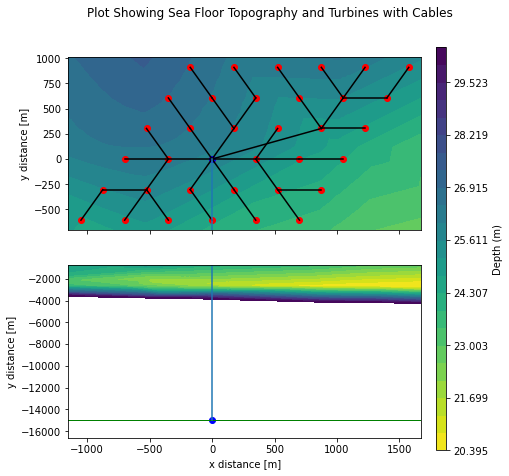

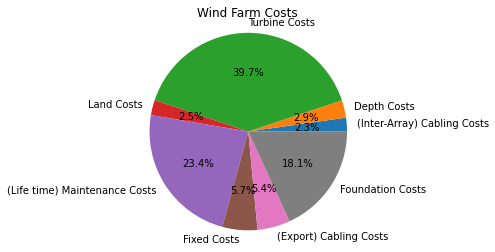

In [62]:
## PRE-OPTIMISED LAYOUT AND GAUSSIAN TESTING

# CALCULATES 
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

## Below calculates max theoreticl power output
wsr_noWake = np.multiply(0.92477772, np.ones(wsr.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)


#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO

print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance)

PayBackTime,DiscountedPayBackTime,NPV,ProfIndex = Payback((np.sum(output)),TotalCost,positionlist)

print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(np.sum(output)/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt:'+'\033[0m',TotalCost/np.sum(output),'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [63]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION

overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

In [64]:
v=2
for amount in range(0,v):
    nturb = nturb - 1
    positionlist = np.delete(positionlist, len(positionlist)-1, 0)
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)

 C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning:Spaces are not permitted in the name. Converted to '_'


In [65]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []
smallestExportDistance = None

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    global smallestExportDistance

    arr2=np.reshape(coord_flat,(-1,2)) # undoes the coordinate flattening
    hull = ConvexHull(arr2)
    arr1 = np.array([np.mean(hull.points[hull.vertices,0]),np.mean(hull.points[hull.vertices,1])])
    arr1 = np.reshape(arr1,(-1,2))
    positionlist = np.concatenate((arr1,arr2),axis=0)
    #positionlist = np.reshape(coord_flat,(-1,2))#np.concatenate((arr1,arr2),axis=0) #np.reshape(coord_flat,(-1,2))
    
    nturb=np.size(positionlist,0)-1 # determines number of turbines (-1 due to the substation)
    print('nturb', nturb)
    
    OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) # calls clustering function
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist) # calls pre-MST function
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist) # Calls MST function
    MSTWeightSum=0
    
    for a in range(0,math.ceil(nturb/maxnodespertree)): 
        MSTWeightSum += MSTweight[a][0] 
#     wsr=windspeedreduction(distance_global,angle_global,angles,model) ## old WSR function
    wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2) # reduced power output due to wake effects
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost= (MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal= (nturb)*CostperTurbine
    MaintenanceCosts= (nturb)*MaintenanceCostperTurbine
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost= TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal

    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###

    CostperWatt = TotalCost/(np.sum(output))
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
        smallestExportDistance = ExportDistance

    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [66]:
angles

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
       220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
       275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325.,
       330., 335., 340., 345., 350., 355.])

In [67]:
# OPTIMIZATION

#xright = 0
#xleft = 0
#yup = 0
#ydown = 0
#for xright in range(0,nturb+1):
 #   if positionlist[xright,0]>0:
  #      positionlist[xright,0] = positionlist[xright,0] + 250
#for xleft in range(0,nturb+1):
 #   if positionlist[xleft,0]<0:
  #      positionlist[xleft,0] = positionlist[xleft,0] - 250
#for yup in range(0,nturb+1):
 #   if positionlist[yup,1]>0:
  #      positionlist[yup,1] = positionlist[yup,1] + 250
#for ydown in range(0,nturb+1):
 #   if positionlist[ydown,1]<0:
  #      positionlist[ydown,1] = positionlist[ydown,1] - 250
        
        
t1_start = perf_counter() # timer starts

dvel=1.5
dang=5
velocities=np.arange(Vc,Vf,dvel)
angles=np.arange(0,360,dang)        
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.

while True:  
    
    iteration_time_start = perf_counter()
    
    #flat_coords=positionlist.flatten() # turns 2D coords into single list of data without any more structure.
    flat_coords=positionlist[1:,:].flatten() # turns 2D coords into single list of data without any more structure.
        
    # b = (Lower bound, Upper bound)
    b2 = ((min(positionlist[:,0]))-1000,(max(positionlist[:,0]))+1000) #bounds for x coordinates
    #b3 = ((OnshoreSubstation[1]+((TooCloseShore-2500))),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    b3 = (((min(positionlist[:,1]))-1000),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    bnd = (b2,b3) #bounds for x,y coordinates of each turbine 
    bnd1 = (bnd*(nturb)) #repeats bnd for the amount of turbines 
    bnds = bnd1 #Combines all bounds into a list for use in the optimization function
    
    #res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, bounds=bnds, options={'disp': 2, 'eps': 50, 'ftol': 1e-17, 'gtol': 1e-17})
    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, options={'disp': 2, 'eps': 50})#, 'ftol': 1e-17, 'gtol': 1e-17})

    #res = minimize(targetfunction, flat_coords, method='Nelder-Mead', jac=False, bounds=bnds, options={'disp': 2, 'xatol': 1e-3, 'fatol': 1e-3})#, 'ftol': 1e-17, 'gtol': 1e-17})
    #res = minimize(targetfunction, flat_coords, method='TNC', jac=False, bounds=bnds, options={'disp': 2, 'eps':50})#, 'ftol': 1e-17, 'gtol': 1e-17})
    
    iteration_time_end = perf_counter()
    print(iteration_time_end-iteration_time_start)
    
    if smallestTotalCost<=budget: #if under budget
        if not res.success:
            print(res.status, res.message) 
        else:
            break # Stops optimization when minimization is under budget after an iteration of 'minimize' 
    else: # over budget then removes a turbine and resets approrate varaibles 
        nturb = nturb - 1 
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        smallestExportDistance = None
        
        wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
        powout=power(wsr,velocities) # total output power
        outputs=np.tensordot(powout,wsp,axes=2)
        LowestPower = min(outputs)
        LowestPowerIndex = np.argmin(outputs)
        LowestPowerTurbine = positionlist[LowestPowerIndex+1,:]
        positionlist = np.delete(positionlist, LowestPowerIndex+1, 0) 

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
          
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

nturb 33


 C:\Users\adamb\OneDrive - University of Warwick\University Documents\3rd Year\ES327 Individual Project\Wind-Farm-Layout-Gaussian-Optimisation\three_desc_model.py:335: RuntimeWarning:invalid value encountered in arccos
 C:\Users\adamb\anaconda3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning:invalid value encountered in q (vectorized)


Total power output in Watts 16743811.722906128 Total Cost in £ 185091379.86477894 £/W 11.054315643765115
smallest cost per watt 11.054315643765115
nturb 33
Total power output in Watts 16779823.47323576 Total Cost in £ 185068410.96730796 £/W 11.02922276044779
smallest cost per watt 11.02922276044779
nturb 33
Total power output in Watts 16773278.020788958 Total Cost in £ 185092912.01545173 £/W 11.034987423808621
smallest cost per watt 11.02922276044779
nturb 33
Total power output in Watts 16811023.623671047 Total Cost in £ 185008420.8648689 £/W 11.00518475295964
smallest cost per watt 11.00518475295964
nturb 33
Total power output in Watts 16799171.037942145 Total Cost in £ 185029692.9579139 £/W 11.01421567409552
smallest cost per watt 11.00518475295964
nturb 33
Total power output in Watts 16778444.65680186 Total Cost in £ 185116408.11314607 £/W 11.032989761545103
smallest cost per watt 11.00518475295964
nturb 33
Total power output in Watts 16814433.041614965 Total Cost in £ 185090299.664

Total power output in Watts 16783585.211093172 Total Cost in £ 185140946.0608467 £/W 11.031072546911913
smallest cost per watt 10.997864061135981
nturb 33
Total power output in Watts 16772289.739284882 Total Cost in £ 185065841.02946043 £/W 11.034023613126006
smallest cost per watt 10.997864061135981
nturb 33
Total power output in Watts 16787415.61644999 Total Cost in £ 185173314.49509925 £/W 11.03048371028879
smallest cost per watt 10.997864061135981
nturb 33
Total power output in Watts 16779058.368670985 Total Cost in £ 185065962.5860888 £/W 11.029579760663726
smallest cost per watt 10.997864061135981
nturb 33
Total power output in Watts 16775634.876619022 Total Cost in £ 185225814.38185468 £/W 11.041359432542995
smallest cost per watt 10.997864061135981
nturb 33
Total power output in Watts 16780830.052255172 Total Cost in £ 185081282.51845482 £/W 11.029328224057771
smallest cost per watt 10.997864061135981
nturb 33
Total power output in Watts 16787811.823265415 Total Cost in £ 18516

Total power output in Watts 17638768.560167797 Total Cost in £ 185070246.82515743 £/W 10.492243049386486
smallest cost per watt 10.459141065571092
nturb 33
Total power output in Watts 17636714.169895496 Total Cost in £ 184987338.52070156 £/W 10.488764332103345
smallest cost per watt 10.459141065571092
nturb 33
Total power output in Watts 17654621.736121207 Total Cost in £ 184995252.8724425 £/W 10.478573579061385
smallest cost per watt 10.459141065571092
nturb 33
Total power output in Watts 17618580.999906294 Total Cost in £ 185007850.35550562 £/W 10.50072365966871
smallest cost per watt 10.459141065571092
nturb 33
Total power output in Watts 17659148.84547003 Total Cost in £ 185013236.20452234 £/W 10.476905643840382
smallest cost per watt 10.459141065571092
nturb 33
Total power output in Watts 17627334.178045295 Total Cost in £ 185000569.023548 £/W 10.495096261008358
smallest cost per watt 10.459141065571092
nturb 33
Total power output in Watts 17657109.19029424 Total Cost in £ 1850307

Total power output in Watts 17658762.757378504 Total Cost in £ 184964833.18266582 £/W 10.474393689069778
smallest cost per watt 10.458652116765922
nturb 33
Total power output in Watts 17659914.69438817 Total Cost in £ 185109313.03428787 £/W 10.481891687342662
smallest cost per watt 10.458652116765922
nturb 33
Total power output in Watts 17663632.562920988 Total Cost in £ 184919765.1490379 £/W 10.468954474133277
smallest cost per watt 10.458652116765922
nturb 33
Total power output in Watts 17674668.913415518 Total Cost in £ 185007620.54101527 £/W 10.46738818403494
smallest cost per watt 10.458652116765922
nturb 33
Total power output in Watts 17659148.8723907 Total Cost in £ 184983465.57845896 £/W 10.475219780703727
smallest cost per watt 10.458652116765922
nturb 33
Total power output in Watts 17691062.45560073 Total Cost in £ 185006712.49494836 £/W 10.45763718031406
smallest cost per watt 10.45763718031406
nturb 33
Total power output in Watts 17653156.550350696 Total Cost in £ 185001085

Total power output in Watts 17641994.913067393 Total Cost in £ 184987589.6909832 £/W 10.485638988250884
smallest cost per watt 10.45763718031406
nturb 33
Total power output in Watts 17667152.301678922 Total Cost in £ 184920128.41936016 £/W 10.46688935838217
smallest cost per watt 10.45763718031406
nturb 33
Total power output in Watts 17660131.169797573 Total Cost in £ 184996737.33492956 £/W 10.47538863421987
smallest cost per watt 10.45763718031406
nturb 33
Total power output in Watts 17671077.973410323 Total Cost in £ 184984246.01228383 £/W 10.468192505891812
smallest cost per watt 10.45763718031406
nturb 33
Total power output in Watts 17677045.941453956 Total Cost in £ 185105832.42872453 £/W 10.471536536239798
smallest cost per watt 10.45763718031406
nturb 33
Total power output in Watts 17679916.495705694 Total Cost in £ 184967646.98530763 £/W 10.462020396433136
smallest cost per watt 10.45763718031406
nturb 33
Total power output in Watts 17647648.682120312 Total Cost in £ 184977015.

Total power output in Watts 17659570.087762296 Total Cost in £ 184958489.3764824 £/W 10.473555610770767
smallest cost per watt 10.454635512124717
nturb 33
Total power output in Watts 17691401.09361997 Total Cost in £ 185096034.3980924 £/W 10.462485894621619
smallest cost per watt 10.454635512124717
nturb 33
Total power output in Watts 17688123.59503705 Total Cost in £ 184958438.4920735 £/W 10.456645528187586
smallest cost per watt 10.454635512124717
nturb 33
Total power output in Watts 17659484.986213706 Total Cost in £ 184938182.71745136 £/W 10.472456182149577
smallest cost per watt 10.454635512124717
nturb 33
Total power output in Watts 17654092.023846168 Total Cost in £ 184953123.2940948 £/W 10.476501597718556
smallest cost per watt 10.454635512124717
nturb 33
Total power output in Watts 17679117.343006354 Total Cost in £ 184975973.39854386 £/W 10.462964287734541
smallest cost per watt 10.454635512124717
nturb 33
Total power output in Watts 17675064.777647357 Total Cost in £ 1849630

Total power output in Watts 17683640.995438874 Total Cost in £ 184983804.34662777 £/W 10.460730592435148
smallest cost per watt 10.448910511121623
nturb 33
Total power output in Watts 17639894.421269152 Total Cost in £ 184948289.74034435 £/W 10.484659676723718
smallest cost per watt 10.448910511121623
nturb 33
Total power output in Watts 17681027.773083415 Total Cost in £ 185005747.40750897 £/W 10.463517719775947
smallest cost per watt 10.448910511121623
nturb 33
Total power output in Watts 17656937.181087177 Total Cost in £ 184962937.0555485 £/W 10.475369264702787
smallest cost per watt 10.448910511121623
nturb 33
Total power output in Watts 17685277.538847934 Total Cost in £ 185123850.99588954 £/W 10.4676814140599
smallest cost per watt 10.448910511121623
nturb 33
Total power output in Watts 17654884.979610234 Total Cost in £ 184933338.7289315 £/W 10.474910425217296
smallest cost per watt 10.448910511121623
nturb 33
Total power output in Watts 17691822.066026 Total Cost in £ 18504373

Total power output in Watts 17666684.60700783 Total Cost in £ 184949536.12840298 £/W 10.468831036641657
smallest cost per watt 10.440054311069678
nturb 33
Total power output in Watts 17684638.822423056 Total Cost in £ 184998982.67587554 £/W 10.460998640317607
smallest cost per watt 10.440054311069678
nturb 33
Total power output in Watts 17668650.55425263 Total Cost in £ 184935415.14408267 £/W 10.466866984336331
smallest cost per watt 10.440054311069678
nturb 33
Total power output in Watts 17665263.08840507 Total Cost in £ 184986752.01226598 £/W 10.471780187280967
smallest cost per watt 10.440054311069678
nturb 33
Total power output in Watts 17683937.294619516 Total Cost in £ 184952209.94465768 £/W 10.45876870423709
smallest cost per watt 10.440054311069678
nturb 33
Total power output in Watts 17651167.798359536 Total Cost in £ 184955269.0745902 £/W 10.478358779852492
smallest cost per watt 10.440054311069678
nturb 33
Total power output in Watts 17688012.937815584 Total Cost in £ 185084

Total power output in Watts 17830676.605646256 Total Cost in £ 185128338.24189594 £/W 10.382575060739606
smallest cost per watt 10.37214193175664
nturb 33
Total power output in Watts 17815355.537516017 Total Cost in £ 185137907.0598395 £/W 10.392041105773696
smallest cost per watt 10.37214193175664
nturb 33
Total power output in Watts 17823334.12783819 Total Cost in £ 185124106.17423972 £/W 10.386614807669186
smallest cost per watt 10.37214193175664
nturb 33
Total power output in Watts 17837062.203266002 Total Cost in £ 185138694.73813018 £/W 10.379438756693403
smallest cost per watt 10.37214193175664
nturb 33
Total power output in Watts 17828055.255094826 Total Cost in £ 185073537.33321404 £/W 10.381027806177823
smallest cost per watt 10.37214193175664
nturb 33
Total power output in Watts 17838129.259204004 Total Cost in £ 185162409.96227178 £/W 10.380147338977984
smallest cost per watt 10.37214193175664
nturb 33
Total power output in Watts 17824981.89108383 Total Cost in £ 185134794.

Total power output in Watts 18163208.496564116 Total Cost in £ 185692404.08104014 £/W 10.223546358352218
smallest cost per watt 10.221316482921834
nturb 33
Total power output in Watts 18138204.52065668 Total Cost in £ 185769694.38189748 £/W 10.241900964912697
smallest cost per watt 10.221316482921834
nturb 33
Total power output in Watts 18141973.519099023 Total Cost in £ 185565179.0294042 £/W 10.228500159260504
smallest cost per watt 10.221316482921834
nturb 33
Total power output in Watts 18141314.410553824 Total Cost in £ 185798523.0015239 £/W 10.241734352690258
smallest cost per watt 10.221316482921834
nturb 33
Total power output in Watts 18137727.929064985 Total Cost in £ 185695272.46711385 £/W 10.238066928413044
smallest cost per watt 10.221316482921834
nturb 33
Total power output in Watts 18121341.8134472 Total Cost in £ 185652900.70012456 £/W 10.24498641498822
smallest cost per watt 10.221316482921834
nturb 33
Total power output in Watts 18110607.093779907 Total Cost in £ 1856774

Total power output in Watts 18158641.883285962 Total Cost in £ 185732652.42975047 £/W 10.228333904239129
smallest cost per watt 10.213857192749336
nturb 33
Total power output in Watts 18167547.889574304 Total Cost in £ 185765220.21114102 £/W 10.225112455475895
smallest cost per watt 10.213857192749336
nturb 33
Total power output in Watts 18146910.55590439 Total Cost in £ 185552172.3321436 £/W 10.225000655649962
smallest cost per watt 10.213857192749336
nturb 33
Total power output in Watts 18165801.78377792 Total Cost in £ 185826869.07929295 £/W 10.229488975556066
smallest cost per watt 10.213857192749336
nturb 33
Total power output in Watts 18378108.836918604 Total Cost in £ 186045918.99793363 £/W 10.12323523866601
smallest cost per watt 10.12323523866601
nturb 33
Total power output in Watts 18360847.261205766 Total Cost in £ 185925807.8361899 £/W 10.126210691215132
smallest cost per watt 10.12323523866601
nturb 33
Total power output in Watts 18357007.65677611 Total Cost in £ 185925858

Total power output in Watts 18350394.005490895 Total Cost in £ 185908254.32148933 £/W 10.131022487356999
smallest cost per watt 10.10767097857563
nturb 33
Total power output in Watts 18394212.2479667 Total Cost in £ 185899072.7228441 £/W 10.106389456465765
smallest cost per watt 10.106389456465765
nturb 33
Total power output in Watts 18354216.82865496 Total Cost in £ 186035282.14938116 £/W 10.135833301202984
smallest cost per watt 10.106389456465765
nturb 33
Total power output in Watts 18383647.678830408 Total Cost in £ 186085026.23194876 £/W 10.122312474810643
smallest cost per watt 10.106389456465765
nturb 33
Total power output in Watts 18358651.27011599 Total Cost in £ 186035863.10408992 £/W 10.133416685512026
smallest cost per watt 10.106389456465765
nturb 33
Total power output in Watts 18385713.219751503 Total Cost in £ 186091765.9891371 £/W 10.121541860514904
smallest cost per watt 10.106389456465765
nturb 33
Total power output in Watts 18366378.504619822 Total Cost in £ 18590317

Total power output in Watts 18762185.536044937 Total Cost in £ 186861102.3416527 £/W 9.959452857060008
smallest cost per watt 9.946712829520512
nturb 33
Total power output in Watts 18771827.7485485 Total Cost in £ 186917003.03518593 £/W 9.9573150541848
smallest cost per watt 9.946712829520512
nturb 33
Total power output in Watts 18748639.349799715 Total Cost in £ 186871511.12208718 £/W 9.967203893336583
smallest cost per watt 9.946712829520512
nturb 33
Total power output in Watts 18761184.74596681 Total Cost in £ 186971923.20734015 £/W 9.965891053204114
smallest cost per watt 9.946712829520512
nturb 33
Total power output in Watts 18755481.92382699 Total Cost in £ 186875888.87444717 £/W 9.963800964081855
smallest cost per watt 9.946712829520512
nturb 33
Total power output in Watts 18755934.676022507 Total Cost in £ 186797241.99460062 £/W 9.959367273410335
smallest cost per watt 9.946712829520512
nturb 33
Total power output in Watts 18776423.904635057 Total Cost in £ 186887985.62857693 £

Total power output in Watts 19956062.556265637 Total Cost in £ 193474826.17077482 £/W 9.695040072422964
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 19932056.279739942 Total Cost in £ 193260643.55360645 £/W 9.695971195407841
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 19937769.79631413 Total Cost in £ 193478190.55496192 £/W 9.704103946005533
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 19952503.384249315 Total Cost in £ 193390150.46998456 £/W 9.69252563177854
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 19945654.80695045 Total Cost in £ 193381277.56757528 £/W 9.695408821583928
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 19946044.490690313 Total Cost in £ 193465348.6878281 £/W 9.699434330356919
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 19954521.05916653 Total Cost in £ 193594585.1915773 

Total power output in Watts 21554473.809457086 Total Cost in £ 210958392.95049384 £/W 9.787220732706324
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 21563420.275554214 Total Cost in £ 210637842.196973 £/W 9.768294616775922
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 21543074.943865806 Total Cost in £ 210755395.00274733 £/W 9.782976457720489
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 21558817.70573313 Total Cost in £ 210311447.31915414 £/W 9.755240300734398
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 21553377.48567531 Total Cost in £ 210983271.23484376 £/W 9.788872828635157
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 21539506.02902104 Total Cost in £ 210833651.73037255 £/W 9.78823058645393
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 21569521.073521484 Total Cost in £ 210747055.5621557 £

Total power output in Watts 21541192.64610921 Total Cost in £ 210515612.18005747 £/W 9.772699944637512
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 21553036.268007405 Total Cost in £ 210761655.88371062 £/W 9.778745475251581
smallest cost per watt 9.683541492703842
nturb 33
Total power output in Watts 20504181.33224884 Total Cost in £ 197533954.24462017 £/W 9.633837657002188
smallest cost per watt 9.633837657002188
nturb 33
Total power output in Watts 20495895.448897332 Total Cost in £ 197487820.68613657 £/W 9.635481464009972
smallest cost per watt 9.633837657002188
nturb 33
Total power output in Watts 20511272.368227888 Total Cost in £ 197391670.82317516 £/W 9.623570263195194
smallest cost per watt 9.623570263195194
nturb 33
Total power output in Watts 20512470.432027806 Total Cost in £ 197524215.1166234 £/W 9.629469827691384
smallest cost per watt 9.623570263195194
nturb 33
Total power output in Watts 20489168.36671159 Total Cost in £ 197496057.0647190

Total power output in Watts 20485287.11210348 Total Cost in £ 197588922.9941851 £/W 9.645406574626044
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20509434.164913602 Total Cost in £ 197512891.75532165 £/W 9.630343293098534
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20484986.853382364 Total Cost in £ 197729371.346458 £/W 9.65240411242002
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20512462.45061908 Total Cost in £ 197422808.5367115 £/W 9.624529917457725
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20505606.050300915 Total Cost in £ 197531474.055016 £/W 9.633047351561563
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20494791.350603096 Total Cost in £ 197533758.6933008 £/W 9.638241995934642
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20505780.81263121 Total Cost in £ 197511795.3529034 £/W 9.

Total power output in Watts 21843209.726728484 Total Cost in £ 216413948.8383398 £/W 9.907607514912264
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21844549.809013493 Total Cost in £ 215878284.34756845 £/W 9.88247806592438
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21839108.357550114 Total Cost in £ 216463666.30761665 £/W 9.911744690473219
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21839933.15861408 Total Cost in £ 216729354.48113528 £/W 9.923535612820919
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21841242.479573946 Total Cost in £ 216208568.36640754 £/W 9.899096563238425
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21841211.88711206 Total Cost in £ 215831202.31505442 £/W 9.881832722039151
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21840205.52193992 Total Cost in £ 216428090.50437713

Total power output in Watts 21118355.05274005 Total Cost in £ 204768759.87479055 £/W 9.69624572384592
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21124084.148541767 Total Cost in £ 205118347.22935054 £/W 9.710165221222631
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21111824.88898046 Total Cost in £ 204919461.10694125 £/W 9.706383137627347
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21113608.95495359 Total Cost in £ 204407635.99193236 £/W 9.68132148454777
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21116450.270919777 Total Cost in £ 204991443.88169017 £/W 9.707665883786882
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21119673.446180012 Total Cost in £ 204816960.5536263 £/W 9.697922701104654
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 21124792.737473194 Total Cost in £ 204488514.21119124 

Total power output in Watts 20564498.65413827 Total Cost in £ 198196579.56327802 £/W 9.637802647009543
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20598203.850865234 Total Cost in £ 198427551.5618014 £/W 9.63324535471409
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20563606.881054208 Total Cost in £ 198233992.58803523 £/W 9.640039985916742
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20585744.959234547 Total Cost in £ 198532633.6049678 £/W 9.644180183817355
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20575975.33903162 Total Cost in £ 198343198.68401933 £/W 9.639552702406867
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20579423.451848418 Total Cost in £ 198135085.44637963 £/W 9.62782489557954
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20584983.164819967 Total Cost in £ 198193061.62638536 

Total power output in Watts 20643288.678178206 Total Cost in £ 198761534.15039524 £/W 9.628385149721996
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20638043.791137405 Total Cost in £ 198875240.08239248 £/W 9.636341607521711
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20648571.751670722 Total Cost in £ 199075243.0771934 £/W 9.641114430158385
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20654591.373366278 Total Cost in £ 199063560.11565596 £/W 9.637738966472357
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20633599.917239178 Total Cost in £ 198584401.39574978 £/W 9.62432160128463
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20649071.553593848 Total Cost in £ 198826438.9857061 £/W 9.628831905088804
smallest cost per watt 9.614804359209653
nturb 33
Total power output in Watts 20647871.71233372 Total Cost in £ 198747094.4786083

Total power output in Watts 20643348.61756494 Total Cost in £ 198852002.30644956 £/W 9.632739629134155
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20654621.09525516 Total Cost in £ 198714168.9667657 £/W 9.62080921505817
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20641338.40571884 Total Cost in £ 198746728.9576954 £/W 9.628577616974251
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20632260.474575642 Total Cost in £ 199249198.44681993 £/W 9.657167652199195
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20640839.53240063 Total Cost in £ 199059507.4300317 £/W 9.643963711726027
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20649750.945454847 Total Cost in £ 198947878.03932738 £/W 9.634396006268405
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20652311.588872835 Total Cost in £ 198856361.54419 £/W 9

Total power output in Watts 20947767.396929007 Total Cost in £ 202212642.1674443 £/W 9.653183479452284
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20945291.79141783 Total Cost in £ 201827675.3384471 £/W 9.63594479123678
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20950150.45925772 Total Cost in £ 202242757.63605857 £/W 9.653522920007907
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20950347.46117023 Total Cost in £ 202337868.34275317 £/W 9.657971960501849
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20949278.634342123 Total Cost in £ 201975405.00013122 £/W 9.64116275913354
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20928403.82065579 Total Cost in £ 202619193.69895777 £/W 9.681540715445193
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20947852.15442164 Total Cost in £ 202234004.47836098 £/W

Total power output in Watts 20773138.89637714 Total Cost in £ 199966589.35096353 £/W 9.626209613696751
smallest cost per watt 9.611326838517629
nturb 33
Total power output in Watts 20755922.926342703 Total Cost in £ 199481328.00918916 £/W 9.610814643949864
smallest cost per watt 9.610814643949864
nturb 33
Total power output in Watts 20761186.12745262 Total Cost in £ 199972820.47947413 £/W 9.632051813024741
smallest cost per watt 9.610814643949864
nturb 33
Total power output in Watts 20751417.47238437 Total Cost in £ 199747306.94033718 £/W 9.625718686743085
smallest cost per watt 9.610814643949864
nturb 33
Total power output in Watts 20764291.991916664 Total Cost in £ 200145343.9144918 £/W 9.638919737422611
smallest cost per watt 9.610814643949864
nturb 33
Total power output in Watts 20763889.36450766 Total Cost in £ 199894910.61741528 £/W 9.627045641993337
smallest cost per watt 9.610814643949864
nturb 33
Total power output in Watts 20757493.2449967 Total Cost in £ 199564770.48451626 £

Total power output in Watts 20810350.664021105 Total Cost in £ 200491563.3051359 £/W 9.63422320661634
smallest cost per watt 9.60989576941153
nturb 33
Total power output in Watts 20836591.874636415 Total Cost in £ 200355238.56521013 £/W 9.615547483516
smallest cost per watt 9.60989576941153
nturb 33
Total power output in Watts 20827744.98088553 Total Cost in £ 200448608.58166197 £/W 9.624114793302002
smallest cost per watt 9.60989576941153
nturb 33
Total power output in Watts 20824320.35007879 Total Cost in £ 200467501.18761516 £/W 9.626604749520993
smallest cost per watt 9.60989576941153
nturb 33
Total power output in Watts 20806735.475223865 Total Cost in £ 200618178.810369 £/W 9.641982474822159
smallest cost per watt 9.60989576941153
nturb 33
Total power output in Watts 20800662.79263003 Total Cost in £ 200930523.64297277 £/W 9.659813518738705
smallest cost per watt 9.60989576941153
nturb 33
Total power output in Watts 20824241.25684274 Total Cost in £ 200626710.83408982 £/W 9.63428

Total power output in Watts 20794961.494964134 Total Cost in £ 200182449.1480388 £/W 9.626488089267033
smallest cost per watt 9.605747050839957
nturb 33
Total power output in Watts 20787450.072578076 Total Cost in £ 200120835.2214137 £/W 9.62700256754457
smallest cost per watt 9.605747050839957
nturb 33
Total power output in Watts 20764085.573898833 Total Cost in £ 200084379.2543074 £/W 9.636079496119025
smallest cost per watt 9.605747050839957
nturb 33
Total power output in Watts 20781835.983882163 Total Cost in £ 200131891.90088218 £/W 9.630135280448712
smallest cost per watt 9.605747050839957
nturb 33
Total power output in Watts 20778107.136188075 Total Cost in £ 200004320.08087993 £/W 9.625723785615847
smallest cost per watt 9.605747050839957
nturb 33
Total power output in Watts 20786858.58456925 Total Cost in £ 199812065.00840464 £/W 9.61242239636592
smallest cost per watt 9.605747050839957
nturb 33
Total power output in Watts 20793085.412194822 Total Cost in £ 200213497.88990128 

Total power output in Watts 20781291.4539279 Total Cost in £ 200122608.73201326 £/W 9.629940909865244
smallest cost per watt 9.605621409528869
nturb 33
Total power output in Watts 20775597.04640364 Total Cost in £ 199957596.1588301 £/W 9.624637776339803
smallest cost per watt 9.605621409528869
nturb 33
Total power output in Watts 20786824.57814397 Total Cost in £ 200165464.84477878 £/W 9.629439267758102
smallest cost per watt 9.605621409528869
nturb 33
Total power output in Watts 20792385.268736593 Total Cost in £ 200229350.97840494 £/W 9.6299365556423
smallest cost per watt 9.605621409528869
nturb 33
Total power output in Watts 20779867.292406976 Total Cost in £ 200435786.78094232 £/W 9.645672128723465
smallest cost per watt 9.605621409528869
nturb 33
Total power output in Watts 20781768.55175744 Total Cost in £ 200046328.00921634 £/W 9.62604927059007
smallest cost per watt 9.605621409528869
nturb 33
Total power output in Watts 20774586.702218406 Total Cost in £ 200202188.50787708 £/W

Total power output in Watts 20800251.687539976 Total Cost in £ 199855046.8111345 £/W 9.608299448167454
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20799626.04789757 Total Cost in £ 200187687.09869513 £/W 9.624581068799078
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20801781.30387265 Total Cost in £ 199670236.84933138 £/W 9.598708588103412
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20782746.955662567 Total Cost in £ 199737264.14227006 £/W 9.610724923340737
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20797303.67964369 Total Cost in £ 199734631.82702124 £/W 9.603871487558294
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20799053.28033457 Total Cost in £ 199756692.67661503 £/W 9.604124283170343
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20805047.45219467 Total Cost in £ 199829691.6855056 £

Total power output in Watts 20881725.27701152 Total Cost in £ 204196164.59189045 £/W 9.778701801842395
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20872003.561746035 Total Cost in £ 203969121.01095492 £/W 9.772378603115378
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20869669.258583643 Total Cost in £ 203968297.92065507 £/W 9.773432218470038
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20846209.326612853 Total Cost in £ 203951829.29680714 £/W 9.783641049619344
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20863242.25444578 Total Cost in £ 203957015.9802821 £/W 9.775902206035143
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20879231.581011668 Total Cost in £ 203981068.80267197 £/W 9.769567812456268
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20876128.684997942 Total Cost in £ 203979560.125637

Total power output in Watts 20871227.37842483 Total Cost in £ 200654252.31874692 £/W 9.61391722109112
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20860103.837857667 Total Cost in £ 200821442.0466128 £/W 9.627058599878819
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20835060.383993324 Total Cost in £ 200503206.61380476 £/W 9.623356156329775
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20853825.327989716 Total Cost in £ 200274349.37211004 £/W 9.603722397315018
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20858167.179972887 Total Cost in £ 200734379.0476787 £/W 9.623778413302546
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20856777.420107506 Total Cost in £ 200661105.84680164 £/W 9.620906519017133
smallest cost per watt 9.598347062863073
nturb 33
Total power output in Watts 20844190.882616717 Total Cost in £ 200477028.4919877

Total power output in Watts 20781365.498267252 Total Cost in £ 200039454.88893378 £/W 9.625905232532148
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20804367.620490834 Total Cost in £ 199906732.36669406 £/W 9.608882904462813
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20788062.081392873 Total Cost in £ 199977554.1621743 £/W 9.619826676444825
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20818030.42025614 Total Cost in £ 200030702.54757452 £/W 9.60853157140854
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20803550.2827756 Total Cost in £ 200037290.04146963 £/W 9.615536161973829
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20802794.032628227 Total Cost in £ 199876567.65513504 £/W 9.608159718431947
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20785596.165551253 Total Cost in £ 199999823.6056158 £/W 9.

Total power output in Watts 20811747.047742993 Total Cost in £ 200257306.4209309 £/W 9.622320796112527
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20818157.83617865 Total Cost in £ 200189562.4369974 £/W 9.616103596308593
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20798365.27645813 Total Cost in £ 200418698.44814074 £/W 9.636271686938617
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20812306.644819982 Total Cost in £ 200536617.0081257 £/W 9.635482526298336
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20813136.512899563 Total Cost in £ 199994388.47686458 £/W 9.609046111474457
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20815293.4259266 Total Cost in £ 200063245.67908657 £/W 9.611358417359456
smallest cost per watt 9.59609739233735
nturb 33
Total power output in Watts 20821045.289494324 Total Cost in £ 200071048.57612577 £/W 9.6

Total power output in Watts 20812557.815537754 Total Cost in £ 200172599.7126222 £/W 9.61787597116881
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20795561.295163583 Total Cost in £ 200120203.3423678 £/W 9.623217209766283
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20807099.88937849 Total Cost in £ 200247559.3674136 £/W 9.62400144335516
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20809137.611557458 Total Cost in £ 199838896.13572773 £/W 9.603420375515062
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20815349.29975515 Total Cost in £ 200047158.1764613 £/W 9.610559750674685
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20802757.11601335 Total Cost in £ 199761899.24638605 £/W 9.602664595483606
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20815014.59146224 Total Cost in £ 200061863.99651548 £/W 

Total power output in Watts 20793963.550000373 Total Cost in £ 199881756.31364566 £/W 9.6124895012448
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20796061.0061693 Total Cost in £ 199956262.3356024 £/W 9.615102700279824
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20790940.95548223 Total Cost in £ 199804028.8925594 £/W 9.61014844495888
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20790070.20460039 Total Cost in £ 200049645.52681062 £/W 9.622365079005071
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20790179.507390514 Total Cost in £ 199912363.11236188 £/W 9.615711256427431
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20782278.86138226 Total Cost in £ 199906316.58328933 £/W 9.61907584421631
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20799162.08524675 Total Cost in £ 199901041.4978938 £/W 9.6

Total power output in Watts 20775448.504899364 Total Cost in £ 199962133.4120266 £/W 9.62492498608974
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20775736.917811196 Total Cost in £ 199978284.68186188 £/W 9.625568781168912
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20805521.049055684 Total Cost in £ 199872729.83222845 £/W 9.606715898196658
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20797486.481289055 Total Cost in £ 199753918.29053968 £/W 9.604714419228157
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20783844.659298074 Total Cost in £ 199809389.67218304 £/W 9.613687599555565
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20794997.61137692 Total Cost in £ 199625417.25823656 £/W 9.599684548606138
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20799643.40674414 Total Cost in £ 199962321.1411738

Total power output in Watts 20783165.072242733 Total Cost in £ 199692839.74794292 £/W 9.608394056141414
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20807369.14640345 Total Cost in £ 200190959.91252252 £/W 9.621156740381352
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20795340.710561153 Total Cost in £ 199601283.41138244 £/W 9.598365623796326
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20789481.401595842 Total Cost in £ 199869329.30829796 £/W 9.613964170022808
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20774384.51803188 Total Cost in £ 199933086.09476265 £/W 9.62401971144914
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20797132.232880354 Total Cost in £ 199862400.01345715 £/W 9.610094207963627
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20789584.272045404 Total Cost in £ 199934864.965848

Total power output in Watts 20791986.83105502 Total Cost in £ 199999868.26358318 £/W 9.619084019660033
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20796075.169028915 Total Cost in £ 199771582.62871546 £/W 9.606215644297649
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20797345.691128913 Total Cost in £ 199813933.4905378 £/W 9.607665153912802
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20799942.316084128 Total Cost in £ 199692040.80761012 £/W 9.600605510006282
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20804943.833789192 Total Cost in £ 199904913.44600973 £/W 9.60852934970895
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20784037.12085982 Total Cost in £ 200347915.77917206 £/W 9.639509139352606
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20808772.866473887 Total Cost in £ 199868830.8387632

Total power output in Watts 20797303.67964369 Total Cost in £ 199774523.69905195 £/W 9.605789614669636
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20799053.28033457 Total Cost in £ 200491344.13984978 £/W 9.639445672722692
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20805047.45219467 Total Cost in £ 199931675.39861375 £/W 9.609767815142545
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20791393.376343913 Total Cost in £ 199808386.70438614 £/W 9.610148924974151
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20803932.417858824 Total Cost in £ 199955974.25687218 £/W 9.611450866146006
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20791771.954149935 Total Cost in £ 199875122.83104223 £/W 9.613183680150366
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20791505.073874332 Total Cost in £ 199611889.846008

Total power output in Watts 20789944.478494048 Total Cost in £ 199841304.20617414 £/W 9.61240201545021
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20788396.461936146 Total Cost in £ 199819057.3568699 £/W 9.612047649886872
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20788474.873594902 Total Cost in £ 200133187.19033736 £/W 9.627122162989574
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20780575.36718281 Total Cost in £ 200239108.48169357 £/W 9.635878937111436
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20797273.73568853 Total Cost in £ 199954643.1969401 £/W 9.614464171513692
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20790377.30745467 Total Cost in £ 199747121.26376322 £/W 9.607671775737384
smallest cost per watt 9.588639227033322
nturb 33
Total power output in Watts 20793240.62971852 Total Cost in £ 199818612.81398988 £

POST-OPTIMISED LAYOUT INFORMATION (GAUSSIAN LAYOUT & TESTING)

Maximum turbines per MST: 10
Number of turbines: 33

Inter-Array Cabling Costs: £ 5822136.780256063
Export Cabling Costs: £ 10272806.52704613
Depth Cost: £ 4629718.529594594
Foundations Cost: £ 33043182.50033414
Turbine Cost: £ 73279052.55366394
Land Cost: £ 18474874.085147414
Maintenance Cost: £ 43230000.0
Fixed Cost: 10607142.857142856

Budget: £ 200000000.0
Total Cost: £ 199358913.83318514
Total Power Output: 20791158.068720642 W
Theoretical Max Total Power Output: 24878497.3637534 W
Percentage power lost to wake effcts: 16.42920484815046 %
Cost per Watt 9.588639227033322 £/W

Payback Time: 8.284082342806595 years
Discounted Payback Time: 12.817705256681968 years
NPV: £ 55589200.60140115 over a  20 year period
Profitability Index: £ 1.278839804714806 over a  20 year period


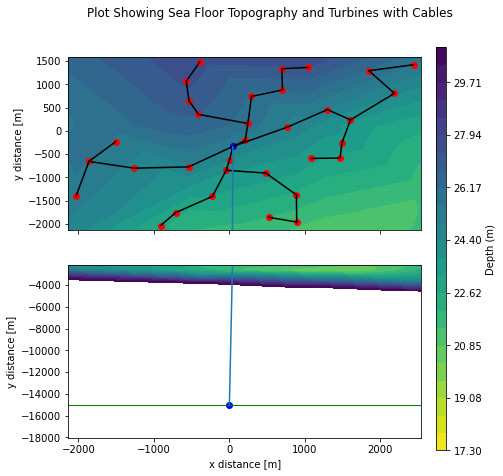

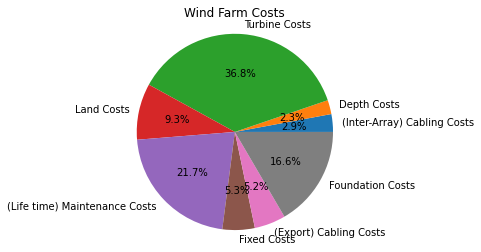

In [68]:
## GUASSIAN LAYOUT AND GAUSSIAN TESTING
## INPUTS (DO NOT OVERWRITE): smallestpositionlist, smallestindiceslist, OptimizedTPO, smallestTotalCost
## Calculates results for the optimised positionlist
distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)
wsr = windspeedreduction(smallestpositionlist[1:,:],angles,predict_class)
powout = power(wsr,velocities) # total output power
output = np.tensordot(powout,wsp,axes=2)
## Below calculates max theoreticl power output
wsr_noWake = np.multiply(0.92477772, np.ones(wsr.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
powout_noWake = power(wsr_noWake,velocities)
output_noWake = np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)

## Displays imported optimised layout
print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (GAUSSIAN LAYOUT & TESTING)'+'\033[0m'+'\033[0m')
print()
OptimizedTPO = smallestTotalCost/smallestCostPerWatt
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data,OnshoreSubstation,smallestExportDistance)
OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(OptimizedTPO,smallestTotalCost,smallestpositionlist)
print('\033[1m'+'Total Power Output:'+'\033[0m', OptimizedTPO, 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(OptimizedTPO/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [73]:
## SAVE VARIABLE TO FILE FOR USE IN OTHER CODE
import pickle

optimised_farm_variables = {'smallestpositionlist': smallestpositionlist, 'smallestindiceslist': smallestindiceslist, 'OptimizedTPO': OptimizedTPO, 'smallestTotalCost': smallestTotalCost, 'smallestCostPerWatt': smallestCostPerWatt, 'smallestExportDistance': smallestExportDistance, 'MSTWeightSum':MSTWeightSum}
with open('optimised_farm_variables.pkl', 'wb') as f:
    pickle.dump(optimised_farm_variables, f)

In [69]:
# ## ATTENUATION LAYOUT AND GAUSSIAN TESTING
# ## note: only valid for the same parameters as the code that generated this layout
# ## IMPORT ATTENUATION LAYOUT
# import pickle
# with open('optimised_farm_variables.pkl', 'rb') as f:
#     my_variables = pickle.load(f)
# PositionList_imported = my_variables['smallestpositionlist'] ## imports tubrine position list
# IndicesList_imported = my_variables['smallestindiceslist']
# ExportDistance_imported = my_variables['smallestExportDistance'] ## imports shore-substation length
# MSTWeightSum_imported = my_variables['MSTWeightSum'] ## imports the total length of cabling (minimum spanning tree)

# ## Calculates various financial data relating to the position list imported
# OnshoreSubstation,ExportDistance_exp = Substation_To_Shore_Connection(PositionList_imported)
# FoundationCostTotal_exp = foundations(PositionList_imported)
# ExportCableCost_exp = (ExportDistance_imported*ExportCableCostperMeter) # Export cable cost
# FixedCost_exp = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
# CableCost_exp = (MSTWeightSum_imported/1000)*IACableCostperMeter
# DepthCostAll_exp = depthvalues(PositionList_imported)[0]
# TurbineCostTotal_exp = (nturb)*CostperTurbine
# MaintenanceCosts_exp = (nturb)*MaintenanceCostperTurbine
# LandCost_exp = LandAreaCost(PositionList_imported,ExportDistance_imported)
# TotalCost_exp = TurbineCostTotal_exp+DepthCostAll_exp+MaintenanceCosts_exp+FixedCost_exp+LandCost_exp+CableCost_exp+ExportCableCost_exp+FoundationCostTotal_exp

# ## Calculates results for the imported optimised positionlist
# distance_exp,angle,distance_global,angle_global = geom_analysis(PositionList_imported,IndicesList_imported)
# MSTweight = Minimum_Spanning_Tree(distance_exp,IndicesList_imported)
# wsr_exp = windspeedreduction(PositionList_imported[1:,:],angles,predict_class)
# powout_exp = power(wsr_exp,velocities) # total output power
# output_exp = np.tensordot(powout_exp,wsp,axes=2)
# TotalPower_exp = np.sum(output_exp)
# CostPerWatt_exp = TotalCost_exp/TotalPower_exp

# ## Below calculates max theoretical power output
# wsr_noWake = np.multiply(0.92477772, np.ones(wsr_exp.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
# powout_noWake = power(wsr_noWake,velocities)
# output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
# TotalPower_noWake = np.sum(output_noWake)

# ## Displays imported optimised layout
# print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (ATTENUATION LAYOUT W/ GAUSSIAN TESTING)'+'\033[0m'+'\033[0m')
# print()
# plotting_function(PositionList_imported,IndicesList_imported,MSTweight,data,OnshoreSubstation,ExportDistance_imported)
# OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(TotalPower_exp,TotalCost_exp,PositionList_imported)
# print('\033[1m'+'Total Power Output:'+'\033[0m', TotalPower_exp, 'W')
# print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', TotalPower_noWake, 'W')
# print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(TotalPower_exp/TotalPower_noWake))*100, '%')
# print('\033[1m'+'Cost per Watt'+'\033[0m',CostPerWatt_exp,'£/W')
# print('')
# print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
# print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
# print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
# print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [70]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.

In [71]:
print(res.success) # whether the minization was succesful or not
print(res.status) # termination status
print(res.message) # Description of the cause of termination
print(res.nit) # number of iterations performed by the optimizer

True
0
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
12
